In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [8]:
filenames = pd.read_csv('../../bats_transformer/data/daytime_files_new/splits/split_filename_to_id.csv')
filenames

,Filename,file_id
0,barn1_D20220301T190226m889-Myyu.wav,0
1,barn1_D20220302T190212m049-Myyu.wav,1
2,barn1_D20220304T190407m280-Myyu.wav,2
3,barn1_D20220308T190728m829-Myyu.wav,3
4,barn1_D20220308T190931m345-Anpa.wav,4
...,...,...
1761,barn1_D20220723T202257m087-Anpa.wav,1761
1762,barn1_D20220723T202312m285-Anpa.wav,1762
1763,barn1_D20220723T202327m236-Anpa.wav,1763
1764,barn1_D20220723T202342m431.wav,1764


In [ ]:
# extract YYYYMMDD after '_D' and add year, month, day columns
filenames['date_str'] = filenames['Filename'].str.extract(r'_D(\d{8})', expand=False)
filenames['date'] = pd.to_datetime(filenames['date_str'], format='%Y%m%d', errors='coerce')
filenames['year'] = filenames['date'].dt.year
filenames['month'] = filenames['date'].dt.month
filenames['day'] = filenames['date'].dt.day

,Filename,file_id,date_str,date,year,month,day
0,barn1_D20220301T190226m889-Myyu.wav,0,20220301,2022-03-01,2022,3,1
1,barn1_D20220302T190212m049-Myyu.wav,1,20220302,2022-03-02,2022,3,2
2,barn1_D20220304T190407m280-Myyu.wav,2,20220304,2022-03-04,2022,3,4
3,barn1_D20220308T190728m829-Myyu.wav,3,20220308,2022-03-08,2022,3,8
4,barn1_D20220308T190931m345-Anpa.wav,4,20220308,2022-03-08,2022,3,8


In [ ]:
# extract 4-letter species code at end of filename (e.g., Myyu, Anpa); set None if not present
filenames['species'] = filenames['Filename'].str.extract(r'[-_]?([A-Za-z]{4})\.wav$', expand=False).fillna("")

,Filename,species
0,barn1_D20220301T190226m889-Myyu.wav,Myyu
1,barn1_D20220302T190212m049-Myyu.wav,Myyu
2,barn1_D20220304T190407m280-Myyu.wav,Myyu
3,barn1_D20220308T190728m829-Myyu.wav,Myyu
4,barn1_D20220308T190931m345-Anpa.wav,Anpa
5,barn1_D20220309T190124m814.wav,
6,barn1_D20220309T190702m978-Myyu.wav,Myyu
7,barn1_D20220311T190451m525.wav,
8,barn1_D20220311T190738m535.wav,
9,barn1_D20220311T191000m119-Myyu.wav,Myyu


In [12]:
filenames

,Filename,file_id,date_str,date,year,month,day,species
0,barn1_D20220301T190226m889-Myyu.wav,0,20220301,2022-03-01,2022,3,1,Myyu
1,barn1_D20220302T190212m049-Myyu.wav,1,20220302,2022-03-02,2022,3,2,Myyu
2,barn1_D20220304T190407m280-Myyu.wav,2,20220304,2022-03-04,2022,3,4,Myyu
3,barn1_D20220308T190728m829-Myyu.wav,3,20220308,2022-03-08,2022,3,8,Myyu
4,barn1_D20220308T190931m345-Anpa.wav,4,20220308,2022-03-08,2022,3,8,Anpa
...,...,...,...,...,...,...,...,...
1761,barn1_D20220723T202257m087-Anpa.wav,1761,20220723,2022-07-23,2022,7,23,Anpa
1762,barn1_D20220723T202312m285-Anpa.wav,1762,20220723,2022-07-23,2022,7,23,Anpa
1763,barn1_D20220723T202327m236-Anpa.wav,1763,20220723,2022-07-23,2022,7,23,Anpa
1764,barn1_D20220723T202342m431.wav,1764,20220723,2022-07-23,2022,7,23,


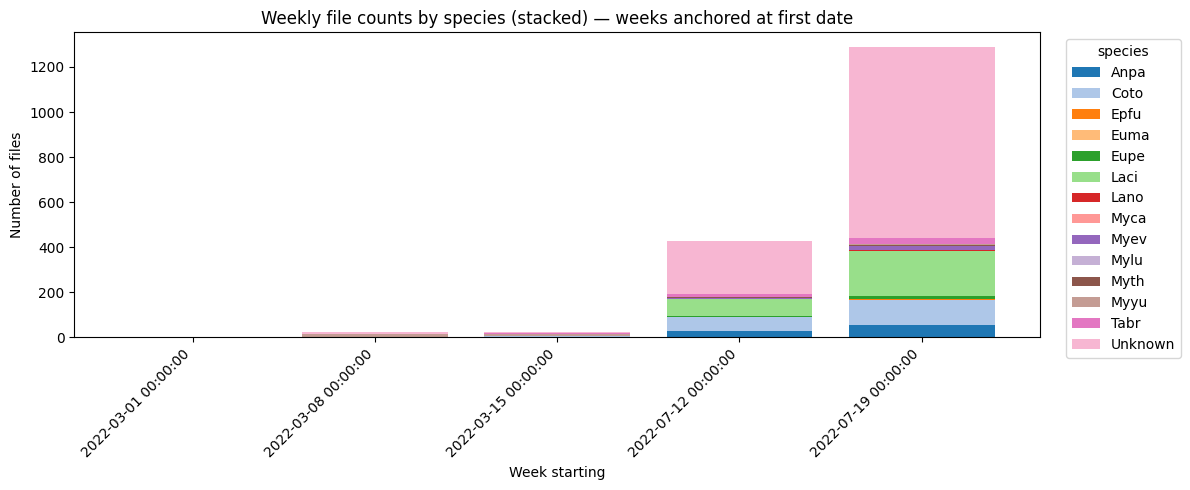

In [19]:
# weekly stacked bar plot of file counts by species (includes empty species)
df = filenames.copy()
df['species'] = df['species'].replace('', 'Unknown')  # include files without species

start = df['date'].min()
end = df['date'].max()

# assign each file to a week anchored at the first date
df['week_start'] = start + pd.to_timedelta(((df['date'] - start).dt.days // 7) * 7, unit='d')
df['week_start'] = pd.to_datetime(df['week_start'])

# pivot to get counts per week per species
counts = df.groupby(['week_start', 'species']).size().unstack(fill_value=0)
counts = counts.sort_index(axis=1)

# plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 5))
counts.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=plt.cm.tab20(np.linspace(0, 1, 20)))
ax.set_xlabel('Week starting')
ax.set_ylabel('Number of files')
ax.set_title('Weekly file counts by species (stacked) — weeks anchored at first date')
ax.legend(title='species', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

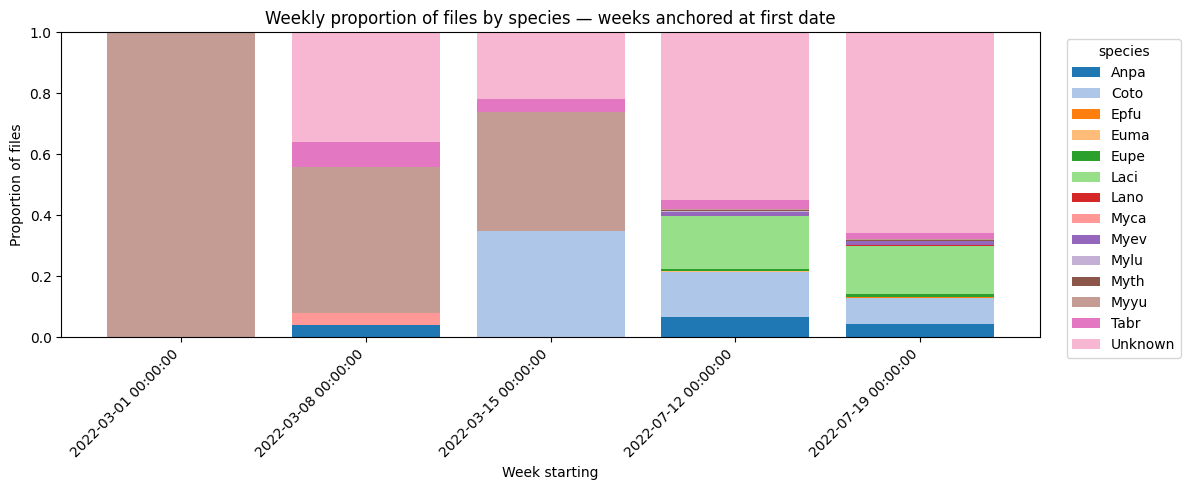

In [18]:
# compute weekly proportions per species and plot stacked bar chart
counts_prop = counts.div(counts.sum(axis=1), axis=0).fillna(0)

fig2, ax2 = plt.subplots(figsize=(12, 5))
counts_prop.plot(kind='bar', stacked=True, ax=ax2, width=0.8, color=plt.cm.tab20(np.linspace(0, 1, 20)))
ax2.set_xlabel('Week starting')
ax2.set_ylabel('Proportion of files')
ax2.set_title('Weekly proportion of files by species — weeks anchored at first date')
ax2.legend(title='species', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()